In [157]:
#Importing our data. I want to predict ethereum price. 


import pandas_datareader as web
from pandas_datareader import data as pdr
import yfinance as yfin
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier

#yfin.pdr_override()

In [23]:
aapl = pdr.get_data_yahoo('AAPL', start=datetime(2018,2,8), end=datetime(2022,3, 10))
gme = pdr.get_data_yahoo('GME', start=datetime(2018,2,8), end=datetime(2022,3, 10))
gld= pdr.get_data_yahoo('GLD', start=datetime(2018,2,8), end=datetime(2022,3, 10))
dow=pdr.get_data_yahoo('^DJI', start=datetime(2018,2,8), end=datetime(2022,3, 10))
eth=pdr.get_data_yahoo('ETH-USD', start=datetime(2018,2,8), end=datetime(2022,3, 10))
btc=pdr.get_data_yahoo('BTC-USD', start=datetime(2018,2,8), end=datetime(2022,3, 10))

In [24]:
aapl['id']='aapl'
gme['id']='gme'
gld['id']='gld'
dow['id']='dow'
eth['id']='eth'
btc['id']='btc'

In [25]:
df_stocks= pd.concat([aapl,gme,gld,dow,eth,btc])

In [26]:
df_stocks
df_stocks.columns

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'id'], dtype='object')

In [27]:
#pivoting to create a dataset. 

cols_s=['id','Adj Close']

df1=df_stocks[cols_s]

In [28]:
df1.columns=['id','adj_close']
df1

,id,adj_close
Date,,
2018-02-08,aapl,37.049881
2018-02-09,aapl,37.503052
2018-02-12,aapl,39.013626
2018-02-13,aapl,39.404453
2018-02-14,aapl,40.130974
...,...,...
2022-03-07,btc,38062.039062
2022-03-08,btc,38737.269531
2022-03-09,btc,41982.925781


In [29]:
#testing a pivot table for our analysis. 
#Creating the adjusted close dataset. 


dfc =pd.pivot_table(df1,values=['adj_close'],index=['Date'],columns=['id'])

dfc =dfc.reset_index()

In [30]:
dfc

Date   adj_close                                           \
id                     aapl           btc           dow          eth   
0    2018-02-08   37.049881   8265.589844  23860.460938   817.807007   
1    2018-02-09   37.503052   8736.980469  24190.900391   883.864990   
2    2018-02-10         NaN   8621.900391           NaN   860.414978   
3    2018-02-11         NaN   8129.970215           NaN   814.659973   
4    2018-02-12   39.013626   8926.570312  24601.269531   868.706970   
...         ...         ...           ...           ...          ...   
1488 2022-03-07  159.300003  38062.039062  32817.378906  2497.771240   
1489 2022-03-08  157.440002  38737.269531  32632.640625  2576.747559   
1490 2022-03-09  162.949997  41982.925781  33286.250000  2729.783447   
1491 2022-03-10  158.520004  39437.460938  33174.070312  2608.048584   
1492 2022-03-11         NaN  38794.972656           NaN  2559.562988   

                              
id           gld         gme  
0     124.980003   13.830752  
1     124.769997   14.127812  
2            NaN         NaN  
3            NaN         NaN  
4     125.370003   13.804542  
...          ...         ...  
1488  186.410004   99.349998  
1489  191.509995  103.010002  
1490  185.820007  105.209999  
1491  186.399994  100.559998  
1492         NaN         NaN  

[1493 rows x 7 columns]

In [31]:
dfc_col = ['date','adj_close_aapl','adj_close_btc','adj_close_dow','adj_close_eth','adj_close_gld',
           'adj_close_gme',]

dfc.columns=dfc_col

In [32]:
#Printing out our dataframe 
dfc

,date,adj_close_aapl,adj_close_btc,adj_close_dow,adj_close_eth,adj_close_gld,adj_close_gme
0,2018-02-08,37.049881,8265.589844,23860.460938,817.807007,124.980003,13.830752
1,2018-02-09,37.503052,8736.980469,24190.900391,883.864990,124.769997,14.127812
2,2018-02-10,NaN,8621.900391,NaN,860.414978,NaN,NaN
3,2018-02-11,NaN,8129.970215,NaN,814.659973,NaN,NaN
4,2018-02-12,39.013626,8926.570312,24601.269531,868.706970,125.370003,13.804542
...,...,...,...,...,...,...,...
1488,2022-03-07,159.300003,38062.039062,32817.378906,2497.771240,186.410004,99.349998
1489,2022-03-08,157.440002,38737.269531,32632.640625,2576.747559,191.509995,103.010002
1490,2022-03-09,162.949997,41982.925781,33286.250000,2729.783447,185.820007,105.209999
1491,2022-03-10,158.520004,39437.460938,33174.070312,2608.048584,186.399994,100.559998


In [33]:
#Getting percent change values for our dataframe. 

dfc['date']=pd.to_datetime(dfc.date)

In [34]:
dfc = dfc.sort_values('date')

c1 =dfc

In [35]:
#Settinng index to date 
 
c1 =c1.set_index(c1['date'])

#dropping the date column 
c1 =c1.drop('date',axis=1)


<AxesSubplot:title={'center':'Adjusted Price over Time'}, xlabel='date'>

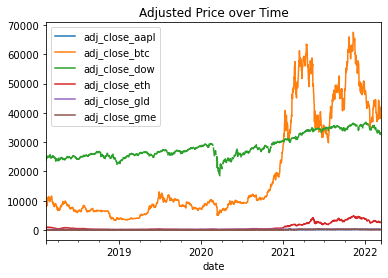

In [36]:
c1.plot(title="Adjusted Price over Time")

In [37]:
#Calculating the percent change of each adjusted price for time series analysis.
#this movement is what we will predict 

pc1= c1.pct_change(fill_method='ffill')
pc1=pc1*100
pc1

,adj_close_aapl,adj_close_btc,adj_close_dow,adj_close_eth,adj_close_gld,adj_close_gme
date,,,,,,
2018-02-08,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-09,1.223137,5.703049,1.384883,8.077454,-0.168032,2.147823
2018-02-10,0.000000,-1.317161,0.000000,-2.653122,0.000000,0.000000
2018-02-11,0.000000,-5.705589,0.000000,-5.317783,0.000000,0.000000
2018-02-12,4.027870,9.798315,1.696378,6.634301,0.480890,-2.288187
...,...,...,...,...,...,...
2022-03-07,-2.371757,-0.931664,-2.372234,-2.241302,1.486287,-11.024543
2022-03-08,-1.167609,1.774026,-0.562928,3.161872,2.735900,3.683949
2022-03-09,3.499742,8.378640,2.002931,5.939111,-2.971118,2.135712


In [38]:
#To model a regression I will shift the dataframe and caclulate the correlation. 
#I will then shift this data over and create a modified linear regression with the shifted
#data. 

In [39]:
#Subsetting for price movements for the past 200 days. 

pc_recent =pc1.tail(100)

In [40]:
#Setting up a function to shift the data.
def df_shift(df, target=None, lag=0):
    if not lag and not target:
        return df       
    new = {}
    for c in df.columns:
        if c == target:
            new[c] = df[target]
        else:
            new[c] = df[c].shift(periods=lag)
    return  pd.DataFrame(data=new)

In [41]:
pc1

,adj_close_aapl,adj_close_btc,adj_close_dow,adj_close_eth,adj_close_gld,adj_close_gme
date,,,,,,
2018-02-08,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-09,1.223137,5.703049,1.384883,8.077454,-0.168032,2.147823
2018-02-10,0.000000,-1.317161,0.000000,-2.653122,0.000000,0.000000
2018-02-11,0.000000,-5.705589,0.000000,-5.317783,0.000000,0.000000
2018-02-12,4.027870,9.798315,1.696378,6.634301,0.480890,-2.288187
...,...,...,...,...,...,...
2022-03-07,-2.371757,-0.931664,-2.372234,-2.241302,1.486287,-11.024543
2022-03-08,-1.167609,1.774026,-0.562928,3.161872,2.735900,3.683949
2022-03-09,3.499742,8.378640,2.002931,5.939111,-2.971118,2.135712


In [42]:
#Setting up a function to shift the data.
def df_shift(df, target=None, lag=0):
    if not lag and not target:
        return df       
    new = {}
    for c in df.columns:
        if c == target:
            new[c] = df[target]
        else:
            new[c] = df[c].shift(periods=lag)
    return  pd.DataFrame(data=new)

Shifting our dataframe for train test split and then model performance measurement. 

In [43]:
#Setting up our shifted dataframe. 
target_variable_user= 'adj_close_gme'
lag_val=1


pc1_new = df_shift(pc1, target_variable_user, lag=lag_val)


In [44]:

print(pc1.tail(10))
print(pc1_new.tail(10))

            adj_close_aapl  adj_close_btc  adj_close_dow  adj_close_eth  \
date                                                                      
2022-03-02        2.058824      -0.970630       1.791270      -0.752458   
2022-03-03       -0.198128      -3.351981      -0.285298      -3.920162   
2022-03-04       -1.840822      -7.806935      -0.532212      -7.666797   
2022-03-05        0.000000       0.671938       0.000000       1.821636   
2022-03-06        0.000000      -2.488799       0.000000      -4.120100   
2022-03-07       -2.371757      -0.931664      -2.372234      -2.241302   
2022-03-08       -1.167609       1.774026      -0.562928       3.161872   
2022-03-09        3.499742       8.378640       2.002931       5.939111   
2022-03-10       -2.718621      -6.063095      -0.337015      -4.459506   
2022-03-11        0.000000      -1.629132       0.000000      -1.859076   

            adj_close_gld  adj_close_gme  
date                                      
2022-03-02   

In [45]:
pc2 =pc1_new.dropna()

#Dropping all rows where apple is zero.

pc2= pc2[pc2[target_variable_user] != 0]

Using AIC criteria to build a model. I will compare just utilizing the dow to create model and then using all variables. Because I am using a lagged dataset, I can utilize the original train test split values to evaluate my predictions. 

In [46]:
#Setting up my data. X for dow and x for all variables. 
#User can either select the recent or the overall dataset from pc2 or pc2_r

X=pc2.adj_close_dow
X_a=pc2.drop(columns=[target_variable_user])

y=np.sign(pc2[target_variable_user])

In [47]:
y.value_counts()




-1.0    534
 1.0    485
Name: adj_close_gme, dtype: int64

In [48]:
#prediction count values. 

534/(534+485)

0.5240431795878312

In [49]:
#Fitting Naive Bayes. 


clf = GaussianNB()
print(cross_val_score(clf, X_a, y, cv=10))




[0.55882353 0.47058824 0.53921569 0.52941176 0.54901961 0.52941176
 0.51960784 0.55882353 0.53921569 0.5049505 ]


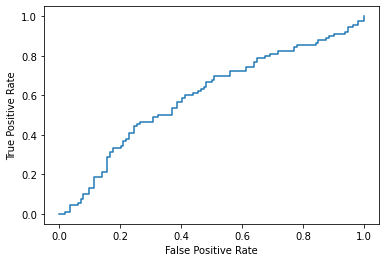

              precision    recall  f1-score   support

        -1.0       0.61      0.81      0.69       114
         1.0       0.58      0.33      0.42        90

    accuracy                           0.60       204
   macro avg       0.59      0.57      0.56       204
weighted avg       0.59      0.60      0.57       204

[[92 22]
 [60 30]]


In [50]:


X_train, X_test, y_train, y_test= train_test_split(X_a, y, test_size=.2, random_state=1)

clf = GaussianNB()
#from sklearn.naive_bayes import CategoricalNB
#m = CategoricalNB(alpha=0)
clf.fit(X_train,y_train)



y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

y_pred= clf.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


In [51]:
clf = LogisticRegression(random_state=0)
print(cross_val_score(clf, X_a, y, cv=10))

[0.54901961 0.49019608 0.54901961 0.43137255 0.54901961 0.52941176
 0.46078431 0.54901961 0.51960784 0.52475248]


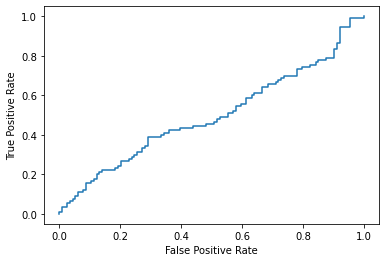

              precision    recall  f1-score   support

        -1.0       0.58      0.88      0.70       114
         1.0       0.56      0.20      0.30        90

    accuracy                           0.58       204
   macro avg       0.57      0.54      0.50       204
weighted avg       0.57      0.58      0.52       204

[[100  14]
 [ 72  18]]


In [52]:
#Creating the logistic regression classifier roc curve and accuracy report

X_train, X_test, y_train, y_test= train_test_split(X_a, y, test_size=.2, random_state=1)

clf = LogisticRegression(random_state=0)
#from sklearn.naive_bayes import CategoricalNB
#m = CategoricalNB(alpha=0)
clf.fit(X_train,y_train)



y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

y_pred= clf.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

In [53]:
clf = SVC(gamma='auto')
scores =cross_val_score(clf, X_a, y, cv=10)
print(scores)
print(sum(scores)/len(scores))

#we have a 3 percent edge on the market, not terrible. 

[0.50980392 0.50980392 0.54901961 0.50980392 0.54901961 0.5
 0.53921569 0.43137255 0.58823529 0.55445545]
0.5240729955348475


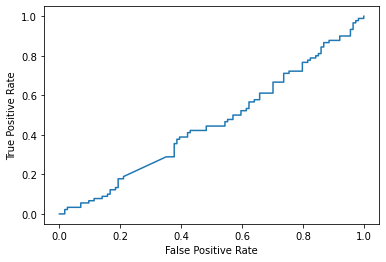

              precision    recall  f1-score   support

        -1.0       0.53      0.50      0.52       114
         1.0       0.41      0.44      0.43        90

    accuracy                           0.48       204
   macro avg       0.47      0.47      0.47       204
weighted avg       0.48      0.48      0.48       204

[[57 57]
 [50 40]]


In [54]:
#Creating the roc curve and accuracy report for the svc classifier. 


X_train, X_test, y_train, y_test= train_test_split(X_a, y, test_size=.2, random_state=1)

clf = SVC(gamma='auto', probability = True)
#from sklearn.naive_bayes import CategoricalNB
#m = CategoricalNB(alpha=0)
clf.fit(X_train,y_train)



y_pred_proba = clf.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

y_pred= clf.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Automatic Data Pull and Preprocessing

The section below performs the analysis above but it is much easier to interchange features and change the number of classes

Below there are 4 strategies being tested:

    -PCA for feature selection, 2 target classes
    -PCA for feature selection, 3 target classes
    -Corr matrix for feature selection, 2 target classes
    -Corr matrix for feature selection, 3 target classes

In [55]:
def pull_stocks_with_pct_change(stock_names: list) -> pd.DataFrame:
    """
    Uses yahoo finance to grab to stock data
    grabs all the columns for all the stocks in stock_names
    returns a concatinated dataframe of all the stocks across available weeks
    Args:
        stock_types: The stock types to be mapped, will be mapped in the same order they appear (list)
        stock_list: The stocks to be fetched, list of lists where each embedded list is grouped by stock type (list)
    Returns:
        pandas: Dataframe of all the columns from yahoo finance for each stock is stock_list, labeled with name and type
    """
    
    #created stocktypes for testing reasons
    
    # Initialize dict that will have all stocks and its type 
    
    fullstockdata = pd.DataFrame(columns = ['Change','Stock Name'])
    
    #Gather open trading days
    appl_days = pdr.get_data_yahoo('AAPL', start=datetime(2018,2,8), end=datetime(2022,3, 10))
    appl_days = appl_days.pct_change().dropna()
    desired_days = list(appl_days.index)
    desired_days = [day.strftime('%Y-%m-%d') for day in desired_days]
    
    for ix,stock in enumerate(stock_names):
        try:
            stockdata = pdr.get_data_yahoo(str(stock.upper()), start=datetime(2018,2,8), end=datetime(2022,3, 10))

            change_data = pd.DataFrame(columns = ['Change','Stock Name'])
            change_data['Change'] = stockdata['Adj Close'].pct_change().dropna()
            change_data['Stock Name'] = stock.upper()

            fullstockdata = pd.concat([fullstockdata,change_data])
        except:
            print("Could not gather data on "+str(stock.upper()))
            pass
        
    change_data_by_stock = fullstockdata.reset_index().pivot(index = 'index', columns = 'Stock Name', values = 'Change')
    change_data_by_stock = change_data_by_stock.loc[desired_days]
    return(change_data_by_stock)

In [83]:
def set_target_classes(n: int, targets: np.array) -> np.array:
    """
    Takes pct_change for a stock as assigns them into bins of size 2 or 3
    Args:
        n: number of bins to assign, if 2 catergories are (-1,1), if 3 categories are (-1,0,1). (int)
        targets: the target values in pct_change (np.array)
    Returns:
        array: target values categorized into n bins
    """
    
    min_change = min(targets)-1
    max_change = max(targets)+1
        
    if n == 2:
        target_cats = pd.cut(targets,[min_change,0,max_change], labels = [0,1])
        
    elif n == 3:
        target_cats = pd.cut(targets,[min_change,-0.005,0.007,max_change], labels = [-1,0,1])
    
    else:
        print('n must be 2 or 3')
    
    return(target_cats)

In [166]:
stocks = ['AAPL','NVDA','FTEC','GOLD','GS','TMUS','MTB','LYG','FRC','GOOG','AAL','CIBR','CVS','TSLA','VOD','EWBC','BAC','RIO','BTG','CI'] 
#
stocks_df = pull_stocks_with_pct_change(stock_names = stocks)

X = stocks_df
y = np.array(stocks_df['AAPL'])

y_cats = set_target_classes(n = 2, targets = y)
y_cats = np.delete(y_cats, 0)

X_shift = X.shift(periods=1).dropna()

In [167]:
np.unique(y_cats, return_counts = True)

(array([0, 1], dtype=int64), array([475, 552], dtype=int64))

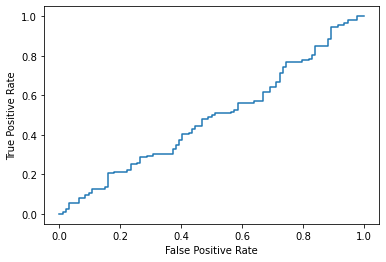

              precision    recall  f1-score   support

           0       0.40      0.34      0.37        94
           1       0.51      0.57      0.54       112

    accuracy                           0.47       206
   macro avg       0.45      0.46      0.45       206
weighted avg       0.46      0.47      0.46       206

[[32 62]
 [48 64]]


In [168]:
X_norm = StandardScaler().fit_transform(X_shift)

X_train, X_test, y_train, y_test= train_test_split(X_norm, y_cats, test_size=.2, random_state=1)

clf = GaussianNB()
clf.fit(X_train,y_train)

y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

y_pred= clf.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

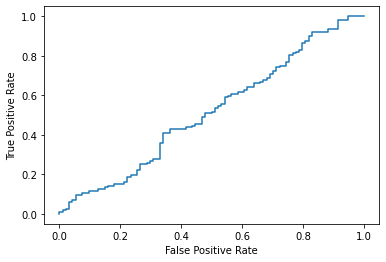

              precision    recall  f1-score   support

           0       0.46      0.33      0.39        94
           1       0.55      0.68      0.61       112

    accuracy                           0.52       206
   macro avg       0.50      0.50      0.50       206
weighted avg       0.51      0.52      0.50       206

[[31 63]
 [36 76]]


In [169]:
#Creating the logistic regression classifier roc curve and accuracy report
X_norm = StandardScaler().fit_transform(X_shift)

X_train, X_test, y_train, y_test= train_test_split(X_norm, y_cats, test_size=.2, random_state=1)

clf = LogisticRegression(random_state=0)
clf.fit(X_train,y_train)


y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

y_pred= clf.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

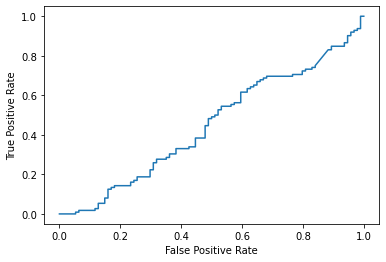

              precision    recall  f1-score   support

           0       0.51      0.36      0.42        94
           1       0.57      0.71      0.63       112

    accuracy                           0.55       206
   macro avg       0.54      0.53      0.53       206
weighted avg       0.54      0.55      0.53       206

[[34 60]
 [33 79]]


In [170]:
#Creating the roc curve and accuracy report for the svc classifier. 
X_norm = StandardScaler().fit_transform(X_shift)

X_train, X_test, y_train, y_test= train_test_split(X_norm, y_cats, test_size=.2, random_state=1)

clf = SVC(C=4, gamma='auto', probability = True)

clf.fit(X_train,y_train)

y_pred_proba = clf.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

y_pred= clf.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

In [ ]:
X_norm = StandardScaler().fit_transform(X_shift)

X_train, X_test, y_train, y_test= train_test_split(X_norm, y_cats, test_size=.2, random_state=1)

clf = RandomForestClassifier(max_depth=4, random_state=0)

clf.fit(X_train,y_train)

# y_pred_proba = clf.predict_proba(X_test)[:,1]
# fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

#create ROC curve
# plt.plot(fpr,tpr)
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()

y_pred= clf.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

## PCA with 3 classes

In [171]:
y_cats = set_target_classes(n = 3, targets = y)
y_cats = np.delete(y_cats, 0)

X_shift = X.shift(periods=1).dropna()

In [172]:
np.unique(y_cats, return_counts = True)

(array([-1,  0,  1], dtype=int64), array([324, 335, 368], dtype=int64))

In [173]:
X_norm = StandardScaler().fit_transform(X_shift)

X_train, X_test, y_train, y_test= train_test_split(X_norm, y_cats, test_size=.2, random_state=1)

clf = GaussianNB()
clf.fit(X_train,y_train)

# y_pred_proba = clf.predict_proba(X_test)[::,1]
# fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

#create ROC curve
# plt.plot(fpr,tpr)
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()

y_pred= clf.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.38      0.13      0.19        62
           0       0.41      0.74      0.53        78
           1       0.33      0.21      0.26        66

    accuracy                           0.39       206
   macro avg       0.37      0.36      0.33       206
weighted avg       0.37      0.39      0.34       206

[[ 8 40 14]
 [ 5 58 15]
 [ 8 44 14]]


In [174]:
#Creating the roc curve and accuracy report for the svc classifier. 
X_norm = StandardScaler().fit_transform(X_shift)

X_train, X_test, y_train, y_test= train_test_split(X_norm, y_cats, test_size=.2, random_state=1)

clf = SVC(C=5, gamma='auto', probability = True)

clf.fit(X_train,y_train)

# y_pred_proba = clf.predict_proba(X_test)[:,1]
# fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

#create ROC curve
# plt.plot(fpr,tpr)
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()

y_pred= clf.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.32      0.27      0.30        62
           0       0.34      0.33      0.34        78
           1       0.29      0.33      0.31        66

    accuracy                           0.32       206
   macro avg       0.32      0.31      0.31       206
weighted avg       0.32      0.32      0.32       206

[[17 23 22]
 [20 26 32]
 [16 28 22]]


In [179]:
X_norm = StandardScaler().fit_transform(X_shift)

X_train, X_test, y_train, y_test= train_test_split(X_norm, y_cats, test_size=.2, random_state=1)

clf = RandomForestClassifier(max_depth=4, random_state=0)

clf.fit(X_train,y_train)

# y_pred_proba = clf.predict_proba(X_test)[:,1]
# fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

#create ROC curve
# plt.plot(fpr,tpr)
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()

y_pred= clf.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.42      0.16      0.23        62
           0       0.36      0.32      0.34        78
           1       0.35      0.59      0.44        66

    accuracy                           0.36       206
   macro avg       0.37      0.36      0.34       206
weighted avg       0.37      0.36      0.34       206

[[10 23 29]
 [ 8 25 45]
 [ 6 21 39]]


## Using High correlation as feature selection

In [180]:
stocks = ['AAPL','NVDA','FTEC','SPY','GS','IVV','FQAL','MSFT','CIBR','GOOG','AMZN','FB','ABT','CSX','ORCL','NSC','CNI','UNP',
         'SPDN','VOO']
stocks_df = pull_stocks_with_pct_change(stock_names = stocks)

X = stocks_df
y = np.array(stocks_df['AAPL'])

y_cats = set_target_classes(n = 2, targets = y)
y_cats = np.delete(y_cats, 0)

X_shift = X.shift(periods=1).dropna()

Could not gather data on FB
Could not gather data on NSC


In [181]:
np.unique(y_cats, return_counts = True)

(array([0, 1], dtype=int64), array([475, 552], dtype=int64))

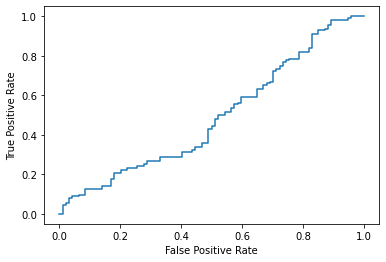

              precision    recall  f1-score   support

           0       0.43      0.30      0.35        94
           1       0.53      0.67      0.59       112

    accuracy                           0.50       206
   macro avg       0.48      0.48      0.47       206
weighted avg       0.49      0.50      0.48       206

[[28 66]
 [37 75]]


In [182]:
X_norm = StandardScaler().fit_transform(X_shift)

X_train, X_test, y_train, y_test= train_test_split(X_norm, y_cats, test_size=.2, random_state=1)

clf = GaussianNB()
clf.fit(X_train,y_train)

y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

y_pred= clf.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

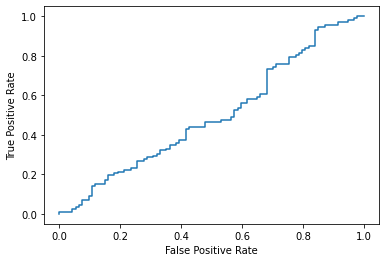

              precision    recall  f1-score   support

           0       0.45      0.32      0.37        94
           1       0.54      0.67      0.60       112

    accuracy                           0.51       206
   macro avg       0.49      0.49      0.49       206
weighted avg       0.50      0.51      0.49       206

[[30 64]
 [37 75]]


In [183]:
#Creating the logistic regression classifier roc curve and accuracy report
X_norm = StandardScaler().fit_transform(X_shift)

X_train, X_test, y_train, y_test= train_test_split(X_norm, y_cats, test_size=.2, random_state=1)

clf = LogisticRegression(random_state=0)
clf.fit(X_train,y_train)


y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

y_pred= clf.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

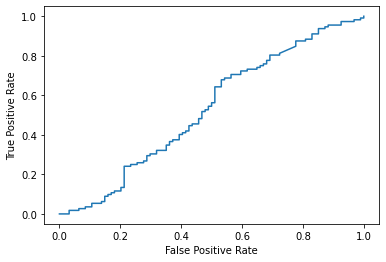

              precision    recall  f1-score   support

           0       0.59      0.21      0.31        94
           1       0.57      0.88      0.69       112

    accuracy                           0.57       206
   macro avg       0.58      0.54      0.50       206
weighted avg       0.58      0.57      0.52       206

[[20 74]
 [14 98]]


In [184]:
#Creating the roc curve and accuracy report for the svc classifier. 
X_norm = StandardScaler().fit_transform(X_shift)

X_train, X_test, y_train, y_test= train_test_split(X_norm, y_cats, test_size=.2, random_state=1)

clf = SVC(gamma='auto', probability = True)

clf.fit(X_train,y_train)

y_pred_proba = clf.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

y_pred= clf.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

In [193]:
X_norm = StandardScaler().fit_transform(X_shift)

X_train, X_test, y_train, y_test= train_test_split(X_norm, y_cats, test_size=.2, random_state=1)

clf = RandomForestClassifier(max_depth=5, random_state=0)

clf.fit(X_train,y_train)

# y_pred_proba = clf.predict_proba(X_test)[:,1]
# fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

#create ROC curve
# plt.plot(fpr,tpr)
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()

y_pred= clf.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.28      0.36        94
           1       0.57      0.79      0.66       112

    accuracy                           0.56       206
   macro avg       0.55      0.54      0.51       206
weighted avg       0.55      0.56      0.53       206

[[26 68]
 [23 89]]


# Corr with 3 classes

In [152]:
y_cats = set_target_classes(n = 3, targets = y)
y_cats = np.delete(y_cats, 0)

X_shift = X.shift(periods=1).dropna()

In [153]:
np.unique(y_cats, return_counts = True)

(array([-1,  0,  1], dtype=int64), array([325, 334, 368], dtype=int64))

In [154]:
X_norm = StandardScaler().fit_transform(X_shift)

X_train, X_test, y_train, y_test= train_test_split(X_norm, y_cats, test_size=.2, random_state=1)

clf = GaussianNB()
clf.fit(X_train,y_train)

# y_pred_proba = clf.predict_proba(X_test)[::,1]
# fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

#create ROC curve
# plt.plot(fpr,tpr)
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()

y_pred= clf.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.48      0.19      0.28        62
           0       0.39      0.76      0.52        78
           1       0.32      0.15      0.21        66

    accuracy                           0.39       206
   macro avg       0.40      0.37      0.33       206
weighted avg       0.40      0.39      0.35       206

[[12 42  8]
 [ 6 59 13]
 [ 7 49 10]]


In [156]:
#Creating the roc curve and accuracy report for the svc classifier. 
X_norm = StandardScaler().fit_transform(X_shift)

X_train, X_test, y_train, y_test= train_test_split(X_norm, y_cats, test_size=.2, random_state=1)

clf = SVC(C=3,gamma='auto', probability = True)

clf.fit(X_train,y_train)

# y_pred_proba = clf.predict_proba(X_test)[:,1]
# fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

#create ROC curve
# plt.plot(fpr,tpr)
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()

y_pred= clf.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.39      0.26      0.31        62
           0       0.34      0.33      0.34        78
           1       0.30      0.41      0.35        66

    accuracy                           0.33       206
   macro avg       0.35      0.33      0.33       206
weighted avg       0.34      0.33      0.33       206

[[16 23 23]
 [13 26 39]
 [12 27 27]]


In [165]:
X_norm = StandardScaler().fit_transform(X_shift)

X_train, X_test, y_train, y_test= train_test_split(X_norm, y_cats, test_size=.2, random_state=1)

clf = RandomForestClassifier(max_depth=4, random_state=0)

clf.fit(X_train,y_train)

# y_pred_proba = clf.predict_proba(X_test)[:,1]
# fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

#create ROC curve
# plt.plot(fpr,tpr)
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()

y_pred= clf.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.54      0.24      0.33        62
           0       0.49      0.45      0.47        78
           1       0.40      0.64      0.49        66

    accuracy                           0.45       206
   macro avg       0.47      0.44      0.43       206
weighted avg       0.47      0.45      0.43       206

[[15 19 28]
 [ 7 35 36]
 [ 6 18 42]]


# The random forrest model using features correlation to apple price and 3 classes seems the most effective